In [340]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [341]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 9.81  # gravity constant m/s^2
BOOST_ACCEL = 15  # thrust constant

# # the following parameters are not being used in the sample code
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height
# ROTATION_ACCEL = 20  # rotation constant

In [342]:
# define system dynamics
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """
        
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... 
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME, 0., 0.])

        # Thrust
        # Note: Same reason as above. Need a 2-by-1 tensor.
        x_vel = BOOST_ACCEL * FRAME_TIME * t.tensor([0., 0., 0., 1.]) * action[0]
        y_vel = BOOST_ACCEL * FRAME_TIME * t.tensor([0., -1., 0., 0.]) * action[1]
        # Drag
        drag = 0.01974 * (y_vel**2)
        y_vel_new = (BOOST_ACCEL - drag) * FRAME_TIME * t.tensor([0., -1., 0., 0.]) * action[1]
        
        # Update velocity
        #state = state + y_vel_new + delta_state_gravity + x_vel
        state = state + y_vel_new + delta_state_gravity + x_vel
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., FRAME_TIME, 0., 0.],
                            [0., 1., 0., 0.],
                            [0., 0., 1., FRAME_TIME],
                            [0., 0., 0., 1.]])
        state = t.matmul(step_mat, state)

        return state

In [343]:
"""
# Demonstrate the inplace operation issue
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        action: thrust or no thrust
        state[0] = x_vel
        state[1] = y_vel_new


        # Update velocity using element-wise operation. This leads to an error from PyTorch.
        state[1] = state[1] + GRAVITY_ACCEL * FRAME_TIME - BOOST_ACCEL * FRAME_TIME * action
        
        # Update state
        step_mat = t.tensor([[1., FRAME_TIME],
                            [0., 1.]])
        state = t.matmul(step_mat, state)

        return state
"""

'\n# Demonstrate the inplace operation issue\nclass Dynamics(nn.Module):\n\n    def __init__(self):\n        super(Dynamics, self).__init__()\n\n    @staticmethod\n    def forward(state, action):\n\n        action: thrust or no thrust\n        state[0] = x_vel\n        state[1] = y_vel_new\n\n\n        # Update velocity using element-wise operation. This leads to an error from PyTorch.\n        state[1] = state[1] + GRAVITY_ACCEL * FRAME_TIME - BOOST_ACCEL * FRAME_TIME * action\n        \n        # Update state\n        step_mat = t.tensor([[1., FRAME_TIME],\n                            [0., 1.]])\n        state = t.matmul(step_mat, state)\n\n        return state\n'

In [344]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [349]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [50, -10, 10, -2]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2

In [350]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
       
        y_co = data[:, 0]
        y_v = data[:, 1]
        x_co = data[:, 2]
        x_v = data[:, 3]
        
        plt.title('X')
        plt.xlabel('Distance')
        plt.ylabel('Velocity')
        plt.plot(x_co, x_v)
        plt.show()
        
        plt.title('Y')
        plt.xlabel('Distance')
        plt.ylabel('Velocity')
        plt.plot(y_co, y_v)
        plt.show()

[1] loss: 41776.980


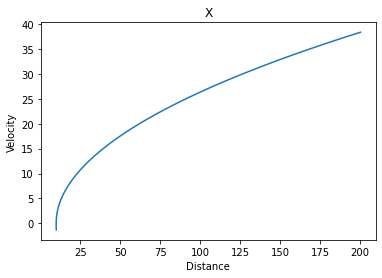

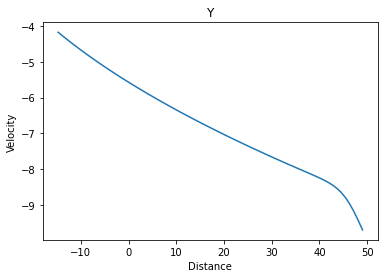

[2] loss: 26072.480


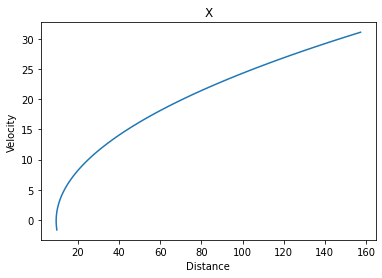

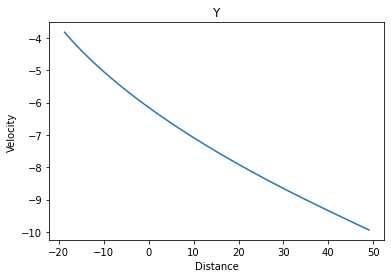

[3] loss: 20540.697


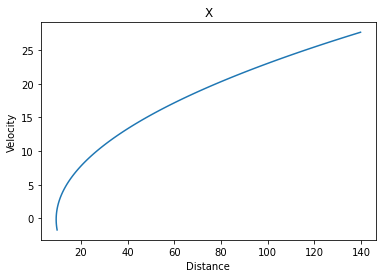

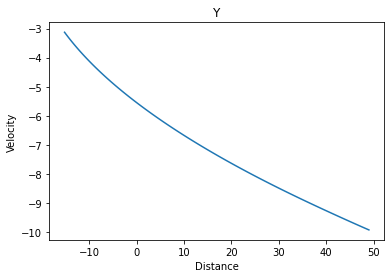

[4] loss: 16248.653


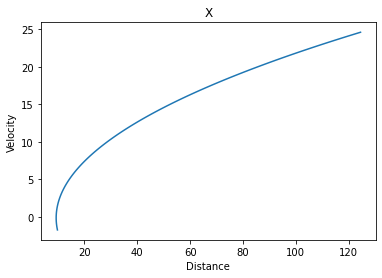

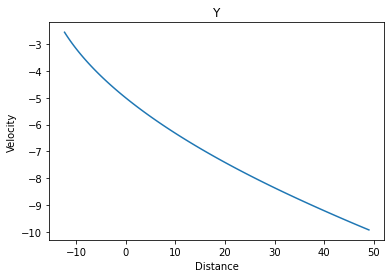

[5] loss: 12893.060


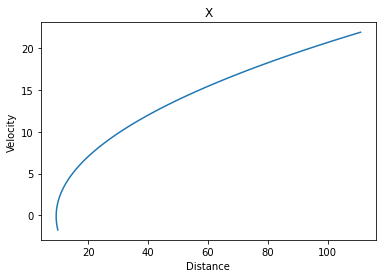

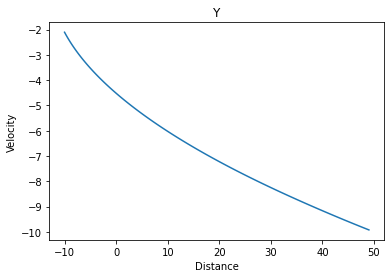

[6] loss: 10254.150


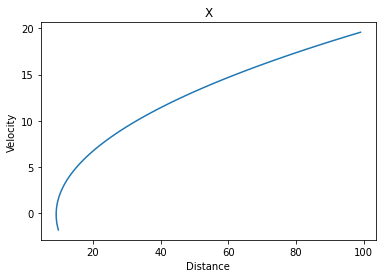

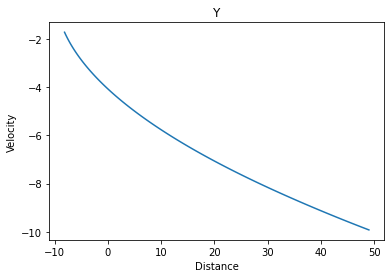

[7] loss: 8169.013


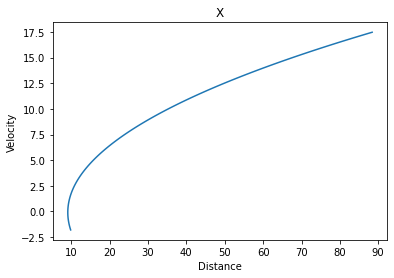

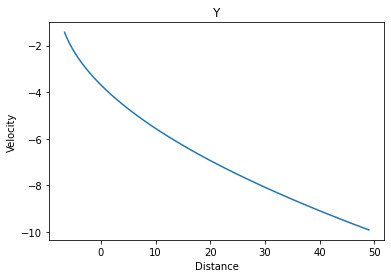

[8] loss: 6500.688


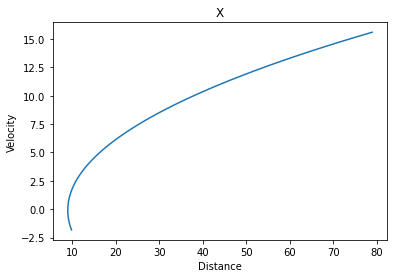

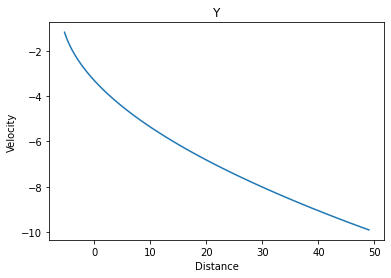

[9] loss: 5188.691


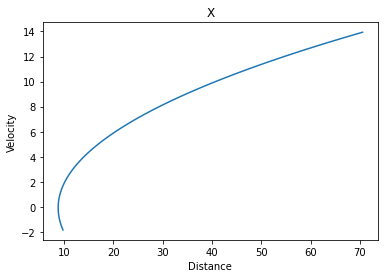

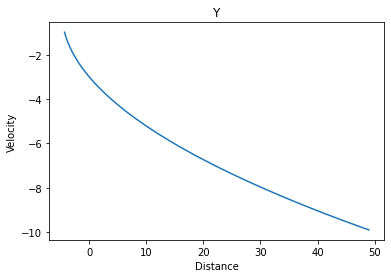

[10] loss: 4139.427


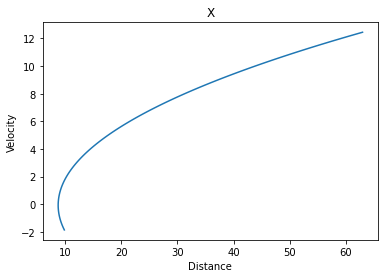

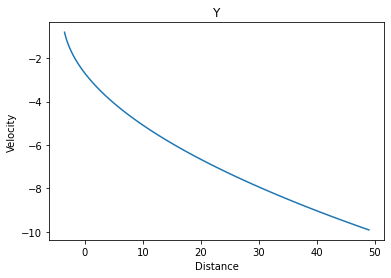

[11] loss: 3302.189


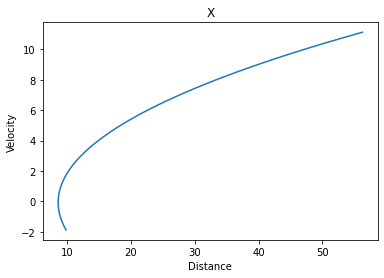

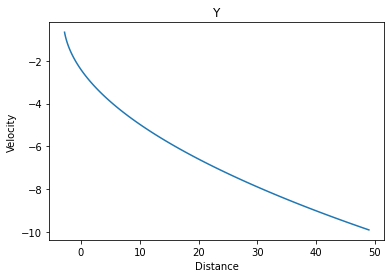

[12] loss: 2634.962


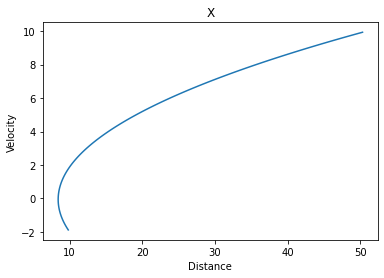

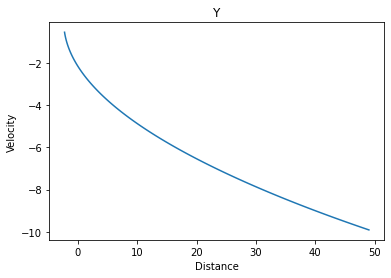

[13] loss: 2093.769


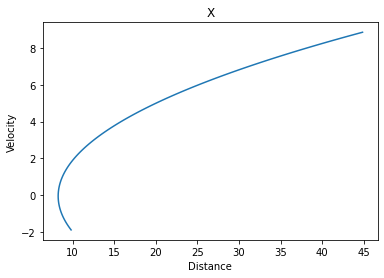

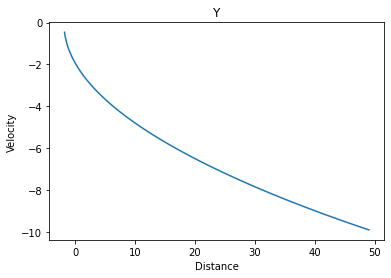

[14] loss: 1668.066


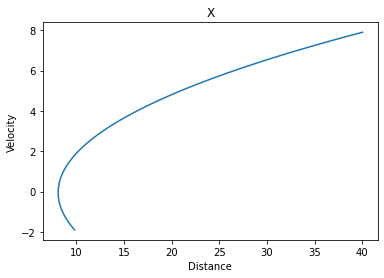

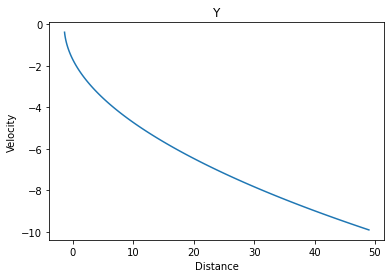

[15] loss: 1326.011


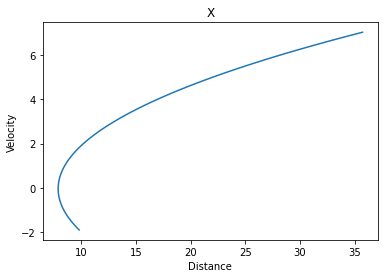

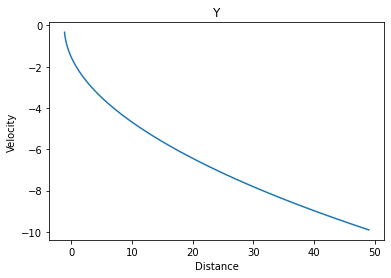

[16] loss: 1051.105


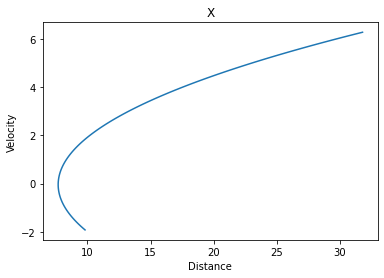

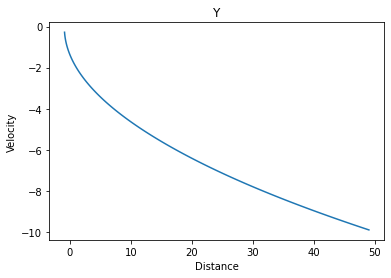

[17] loss: 833.022


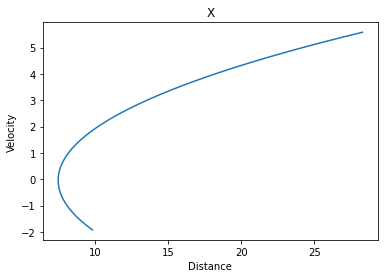

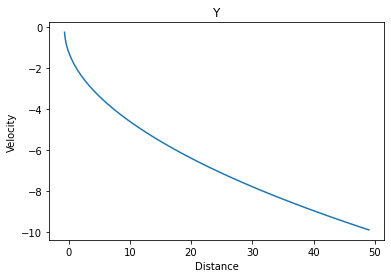

[18] loss: 656.005


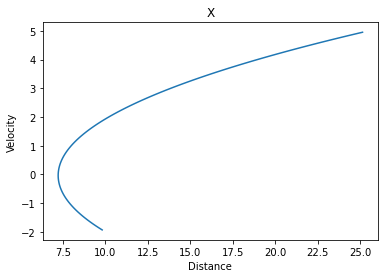

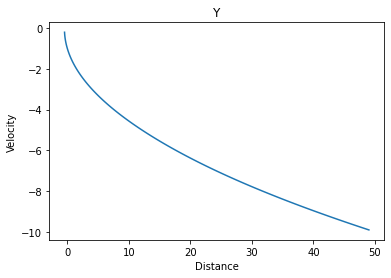

[19] loss: 517.230


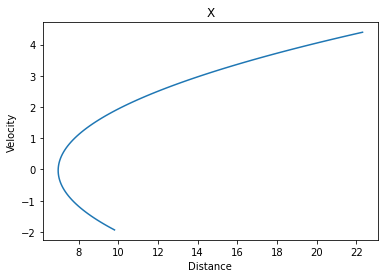

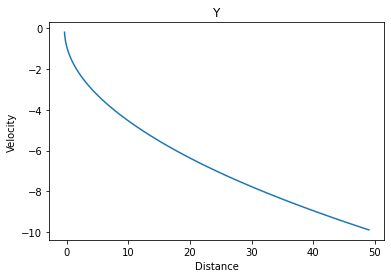

[20] loss: 406.633


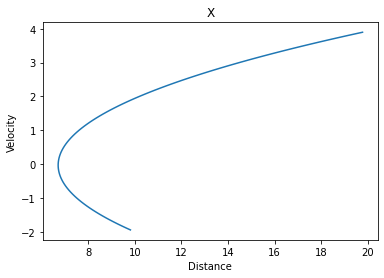

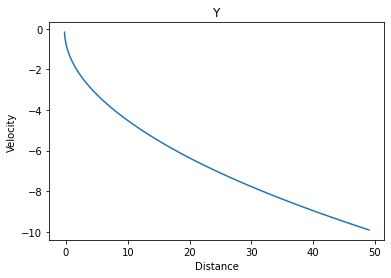

[21] loss: 317.881


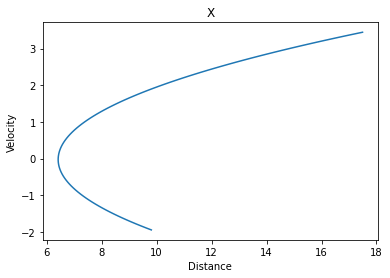

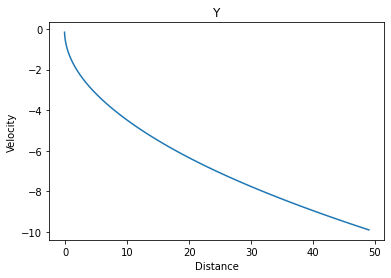

[22] loss: 248.219


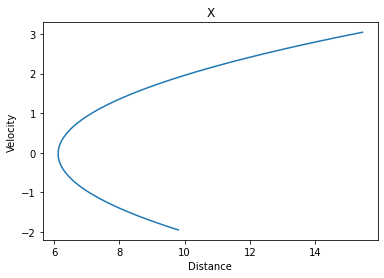

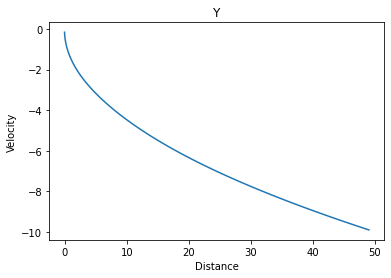

[23] loss: 192.566


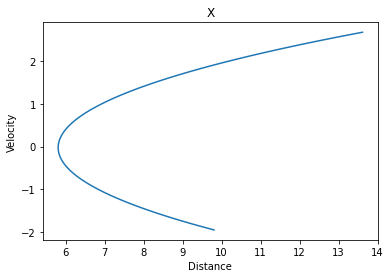

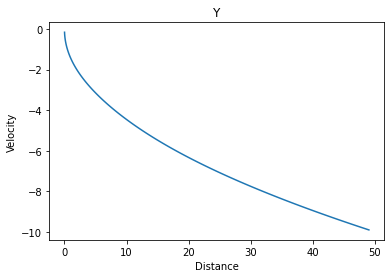

[24] loss: 149.022


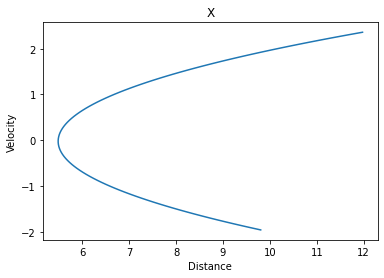

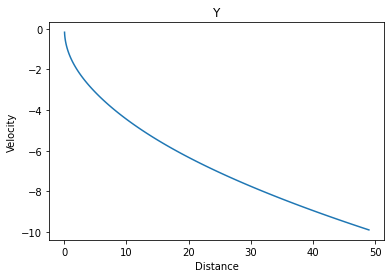

[25] loss: 115.034


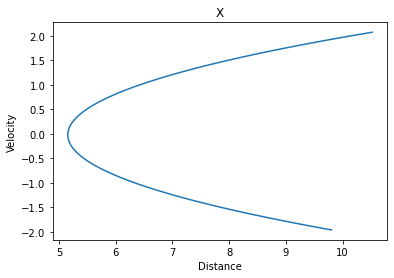

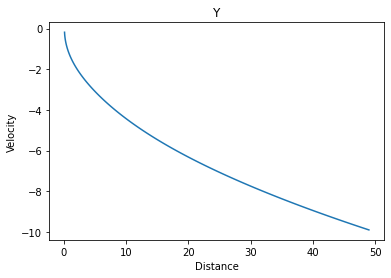

[26] loss: 88.293


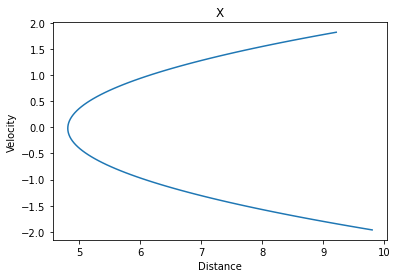

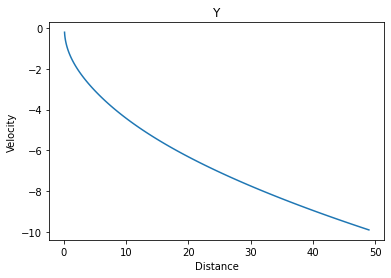

[27] loss: 67.583


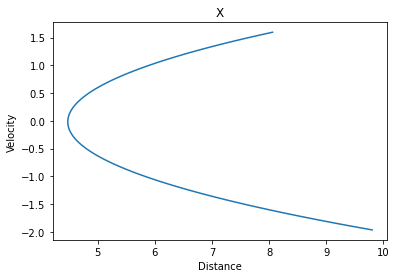

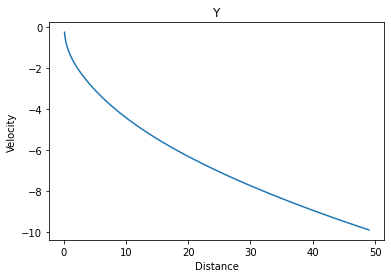

[28] loss: 51.552


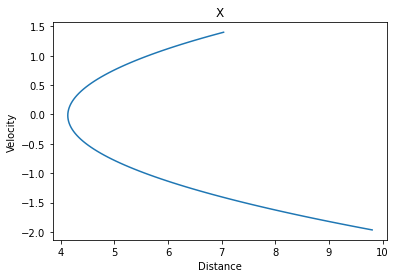

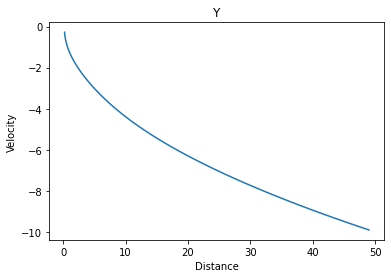

[29] loss: 39.186


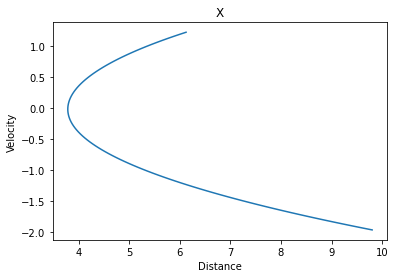

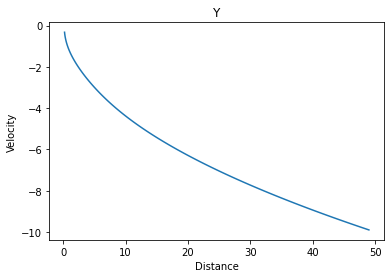

[30] loss: 29.815


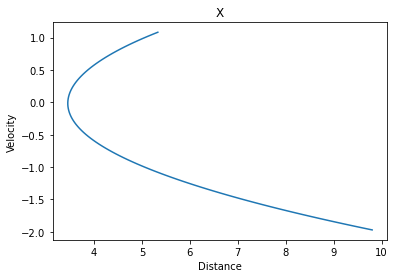

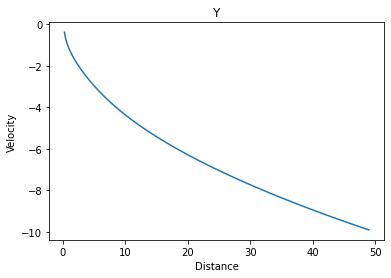

[31] loss: 22.707


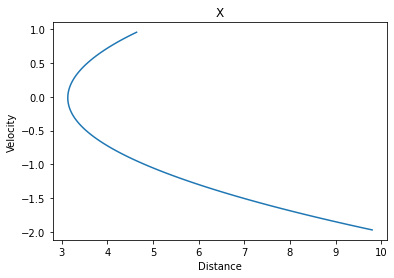

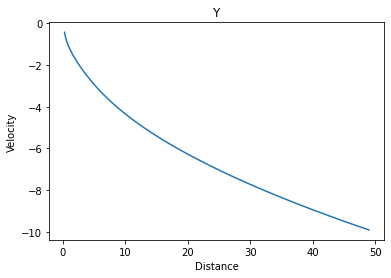

[32] loss: 17.357


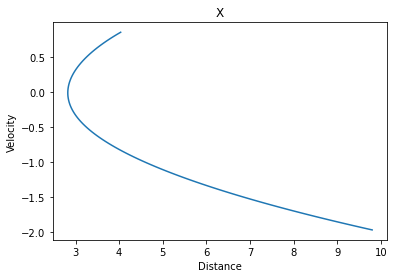

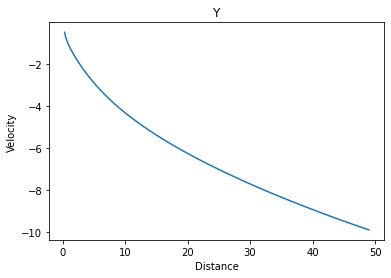

[33] loss: 13.366


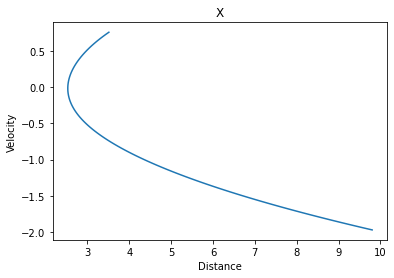

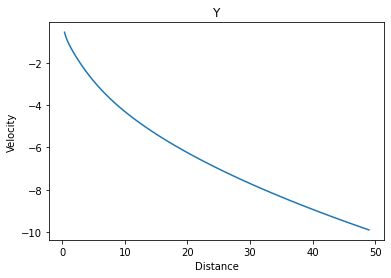

[34] loss: 10.389


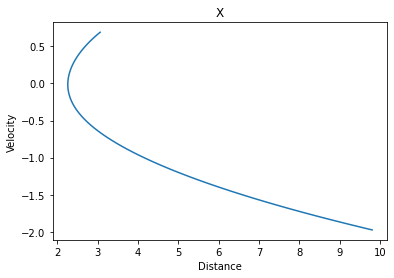

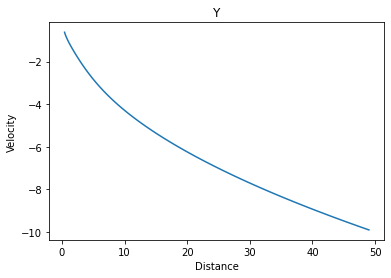

[35] loss: 8.190


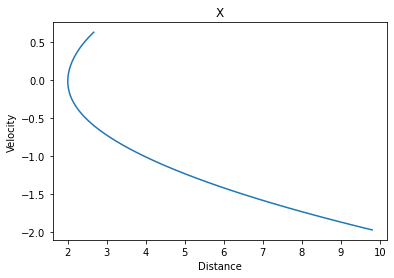

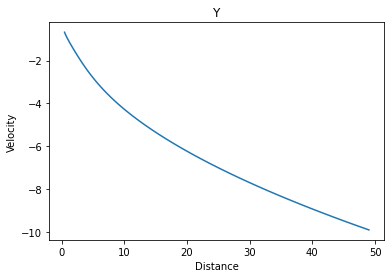

[36] loss: 6.563


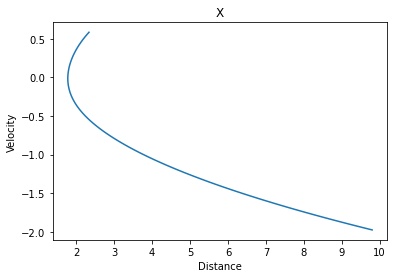

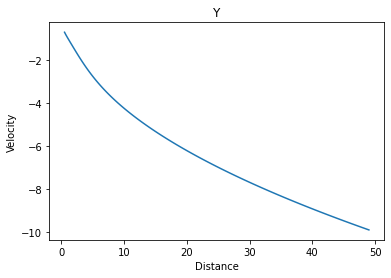

[37] loss: 5.356


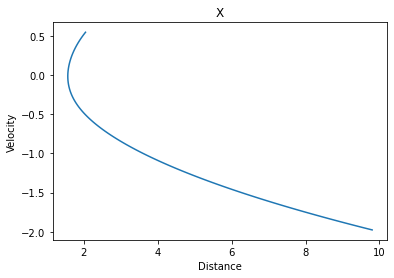

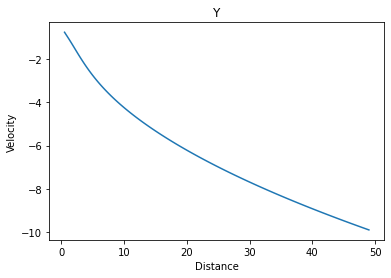

[38] loss: 4.456


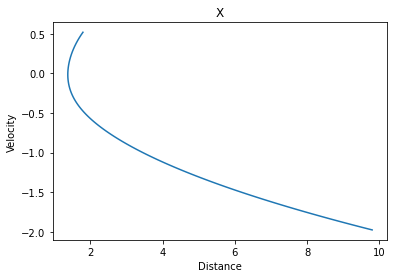

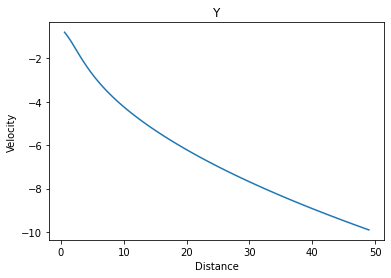

[39] loss: 3.783


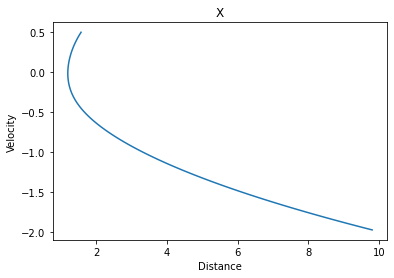

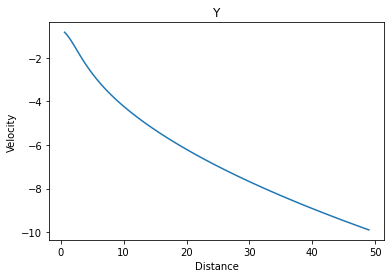

[40] loss: 3.277


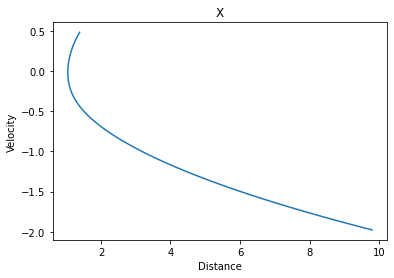

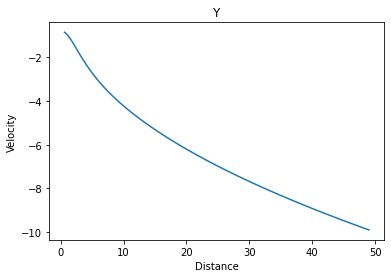

[41] loss: 2.895


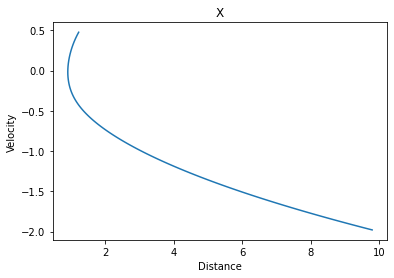

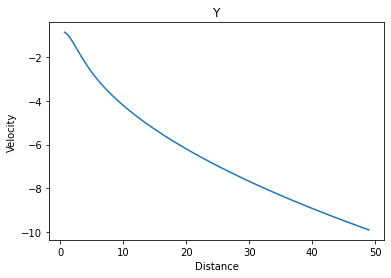

[42] loss: 2.598


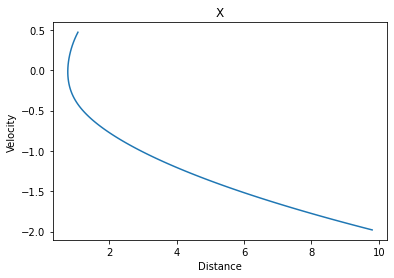

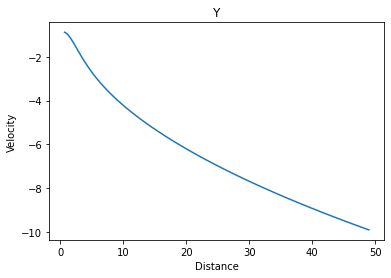

[43] loss: 2.366


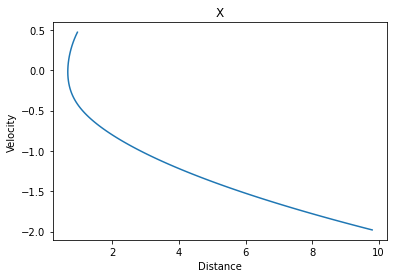

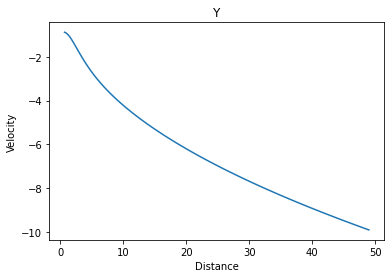

[44] loss: 2.173


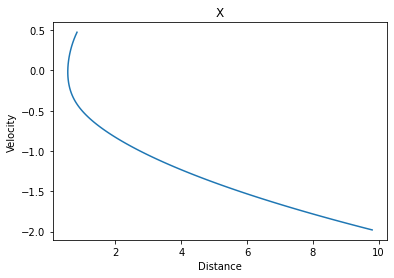

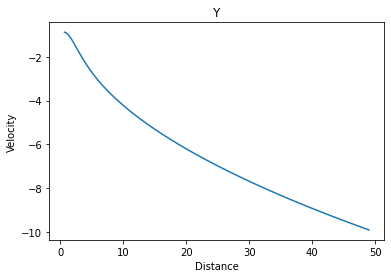

[45] loss: 1.947


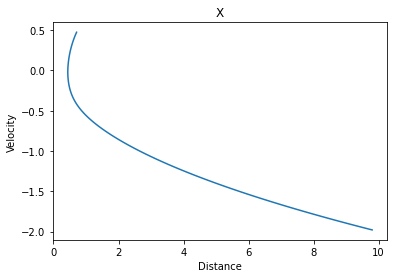

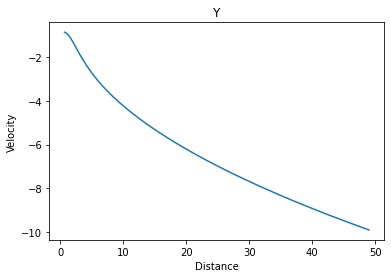

[46] loss: 1.675


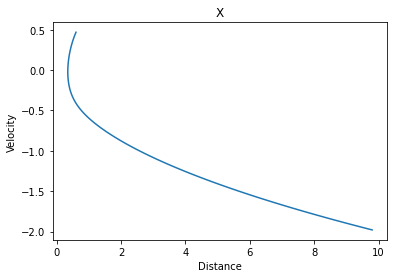

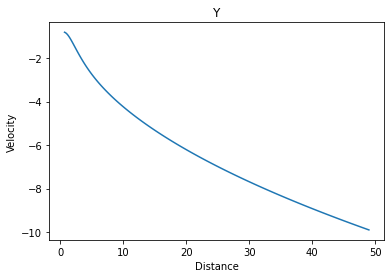

[47] loss: 1.396


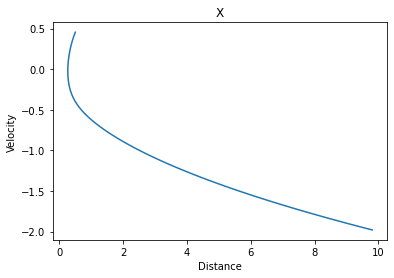

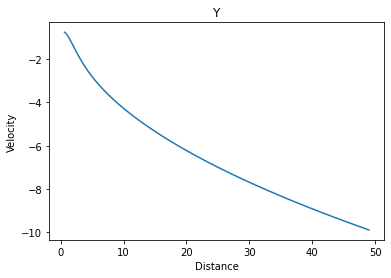

[48] loss: 1.124


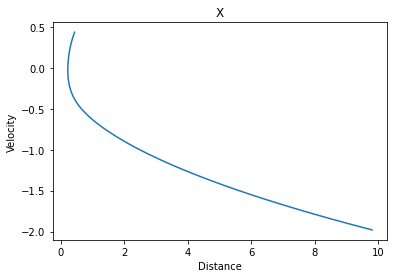

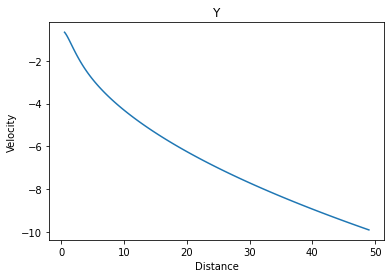

[49] loss: 0.886


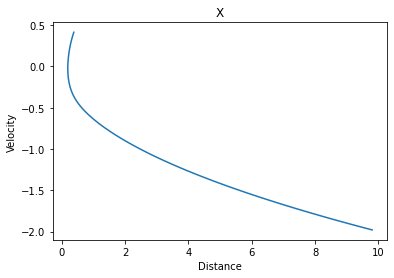

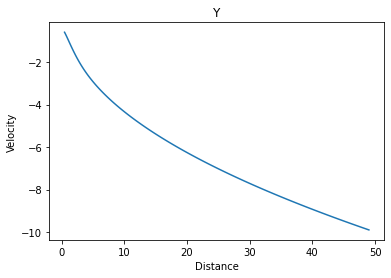

[50] loss: 0.686


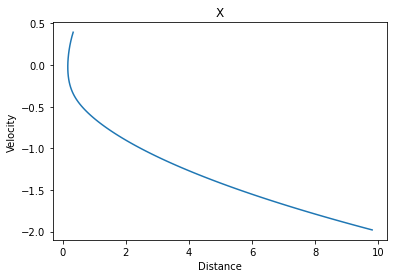

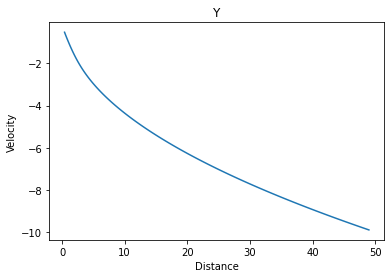

[51] loss: 0.521


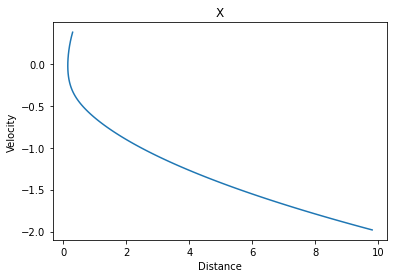

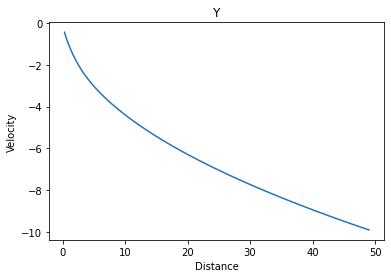

[52] loss: 0.386


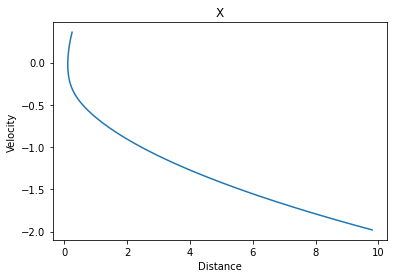

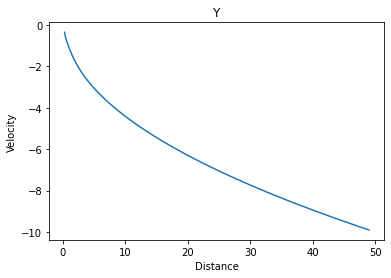

[53] loss: 0.296


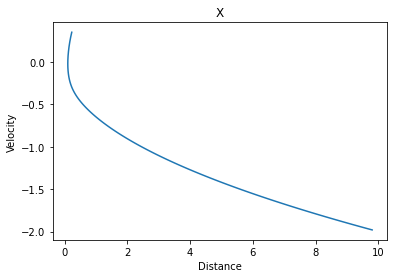

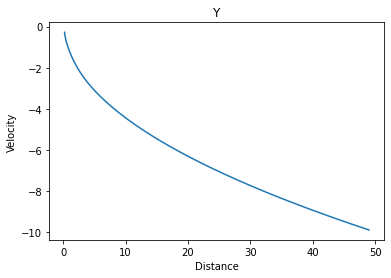

[54] loss: 0.232


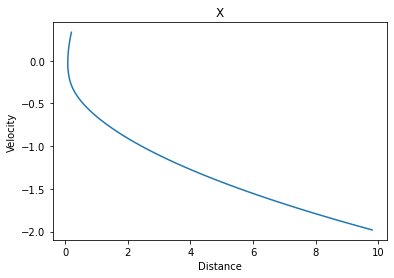

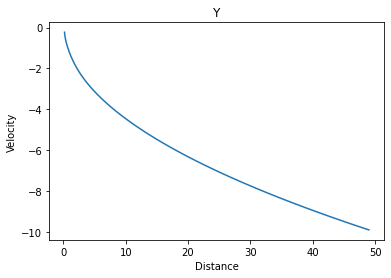

[55] loss: 0.238


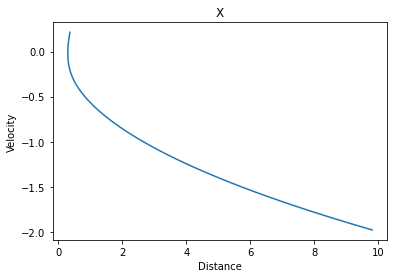

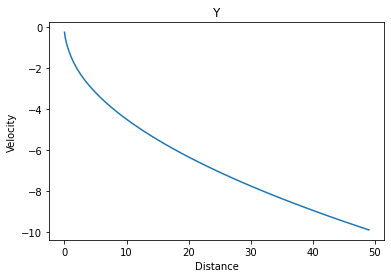

[56] loss: 0.147


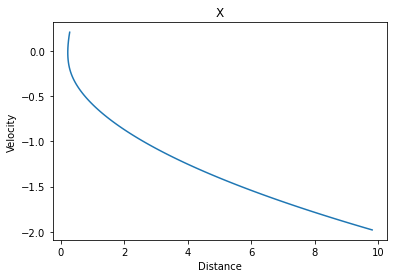

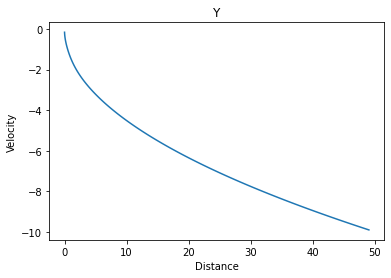

[57] loss: 0.104


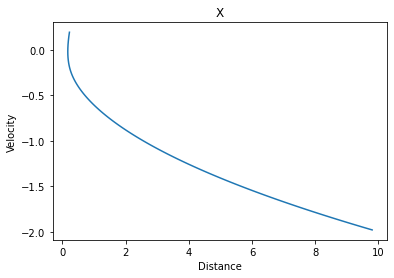

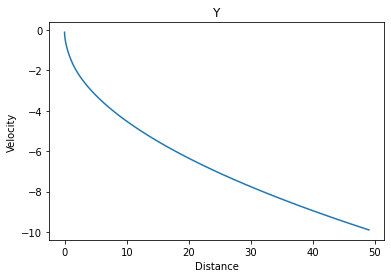

[58] loss: 0.075


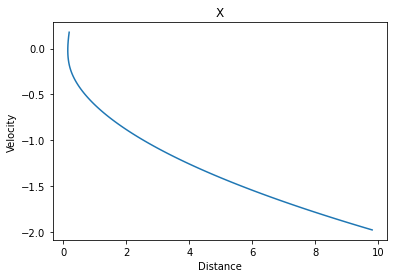

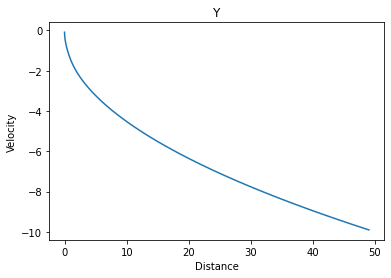

[59] loss: 0.055


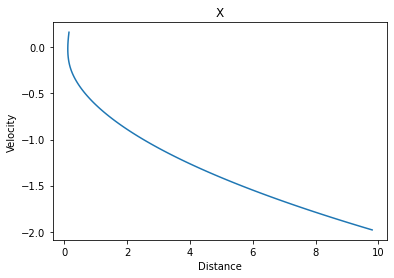

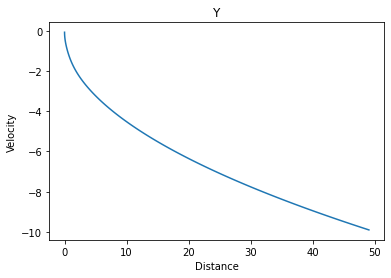

[60] loss: 0.041


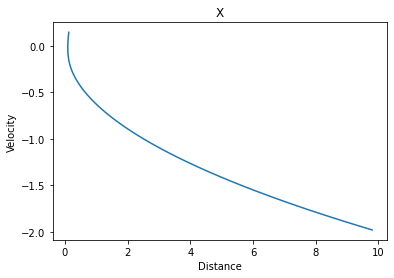

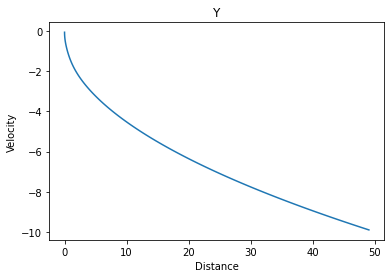

[61] loss: 0.031


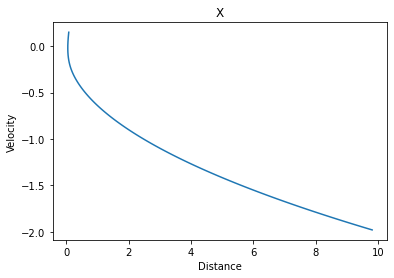

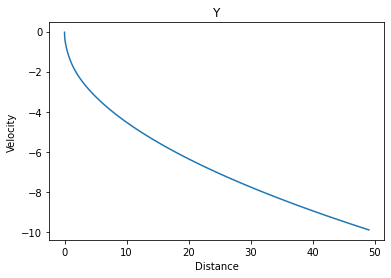

[62] loss: 0.023


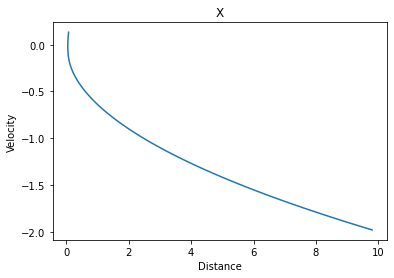

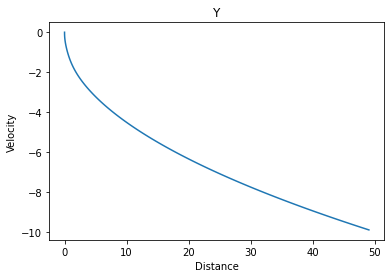

[63] loss: 0.017


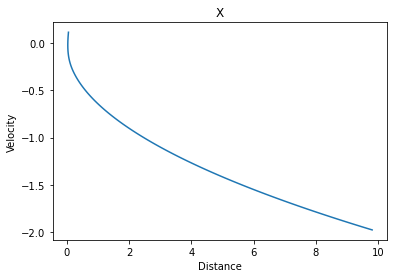

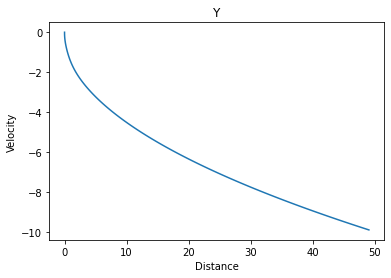

[64] loss: 0.013


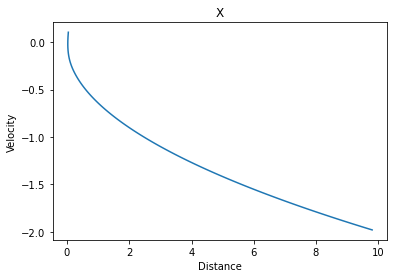

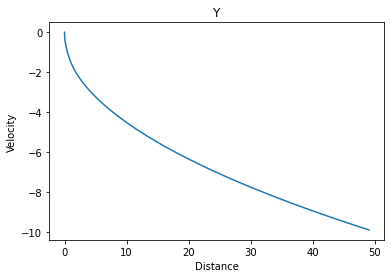

[65] loss: 0.009


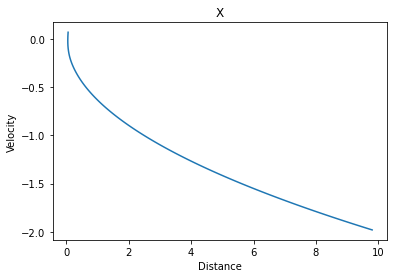

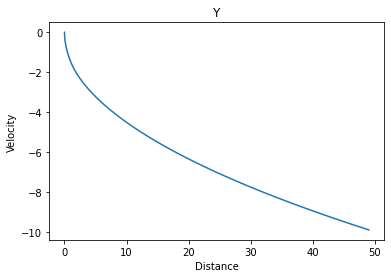

[66] loss: 0.006


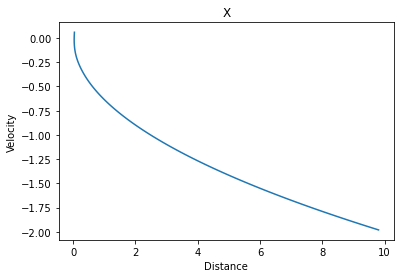

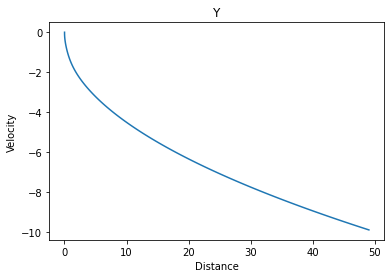

[67] loss: 0.004


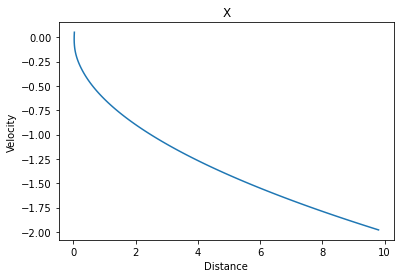

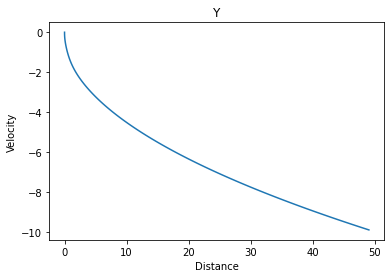

[68] loss: 0.003


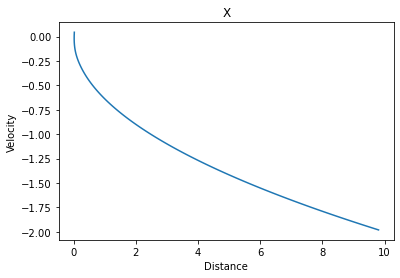

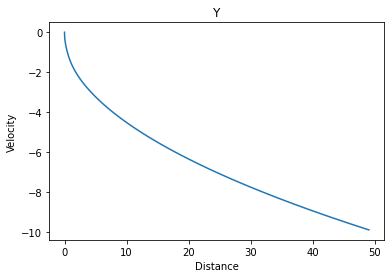

[69] loss: 0.002


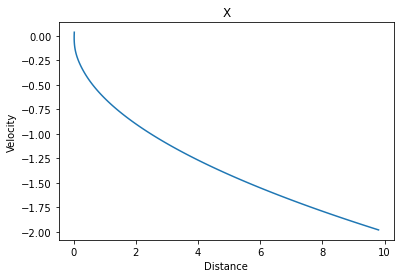

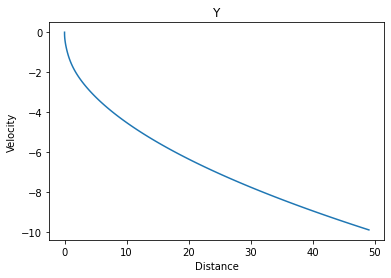

[70] loss: 0.001


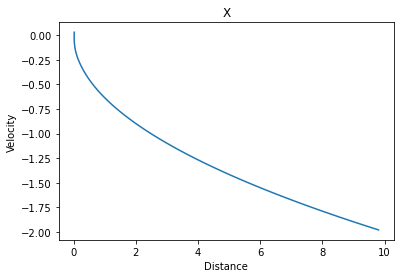

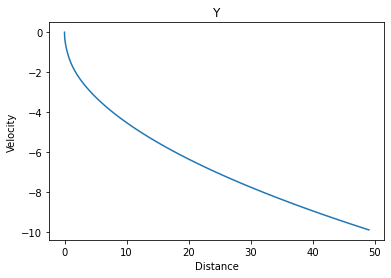

In [352]:
# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 4  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(70)  # solve the optimization problem